In [1]:
# from IPython.display import Image, display
# display(Image(filename='../additional_files/accTosf_algo.png'))

In [2]:
from scipy.signal import find_peaks
import numpy as np
import pandas as pd
from ssqueezepy import ssq_cwt
import matplotlib.pyplot as plt
# Frequency sampling
FS = 32
# Valid duration
T = 10
# Segment threshold
A = 0.3

In [3]:
def peak2peak(magnitude_vec: np.ndarray) -> float:
    peaks_idx, _ = find_peaks(magnitude_vec)
    if(peaks_idx.size > 1):
        peaks_value = magnitude_vec[peaks_idx]
        sorted_idx = np.argsort(peaks_value)
        return peaks_value[sorted_idx[-1]] - peaks_value[sorted_idx[-2]]
    return 0

In [4]:
# Read data
df = pd.read_csv('../additional_files/ACC.csv', skiprows=2, header=None)
df.columns = ['x', 'y', 'z']
magnitude = np.linalg.norm(df, axis=1)-1

In [5]:
# Split data into segments
magnitude = magnitude[:len(magnitude)-len(magnitude)%32]
magnitude_segments = magnitude.reshape(-1,FS)

In [6]:
# Calculate peak-to-peak amp in each segment
ptp_amp = np.apply_along_axis(peak2peak,axis=1,arr=magnitude_segments)

In [7]:
# Find segments above A
magnitude_segments[ptp_amp < A] = 0

In [8]:
# # Ask Eran about cone of influance
# from scipy.signal.windows import tukey
# # Create window for CWT, M=(number of valid segments)*(Length of segment)
# # window = tukey(np.sum(ptp_amp > A)*FS, alpha=0.02, sym=True)
# window = tukey(len(magnitude), alpha=0.02, sym=True)

In [ ]:
# Compute CWT over the entire signal
wavelet = ('gmw', {'beta':90,'gamma':3})
magnitude_cwt = ssq_cwt(magnitude[:-1], wavelet=wavelet, fs=FS)
coefs = magnitude_cwt[0]
coefs = np.append(coefs, coefs[:, -1:], 1)

# magnitude of cwt
coefs = np.abs(coefs**2)

# interpolate coefficients
freqs = magnitude_cwt[2]
freqs_interp = np.arange(0.5, 4.5, 0.05)
from scipy import interpolate
ip = interpolate.interp2d(range(coefs.shape[1]), freqs, coefs)
coefs_interp = ip(range(coefs.shape[1]), freqs_interp)

# trim spectrogram from the coi
coefs_interp = coefs_interp[:, 5*FS:-5*FS]



In [ ]:
def viz(Tx, Wx):
    plt.imshow(np.abs(Wx), aspect='auto', cmap='turbo')
    plt.colorbar()
    plt.title('Wx')
    plt.show()
    plt.imshow(np.abs(Tx), aspect='auto', vmin=0, vmax=.2, cmap='turbo')
    plt.colorbar()
    plt.title('Tx')
    plt.show()

plt.title('magnitude original signal')
plt.plot(magnitude[:-1]); plt.show()

Twxo, Wxo, *_ = magnitude_cwt
viz(Twxo, Wxo)

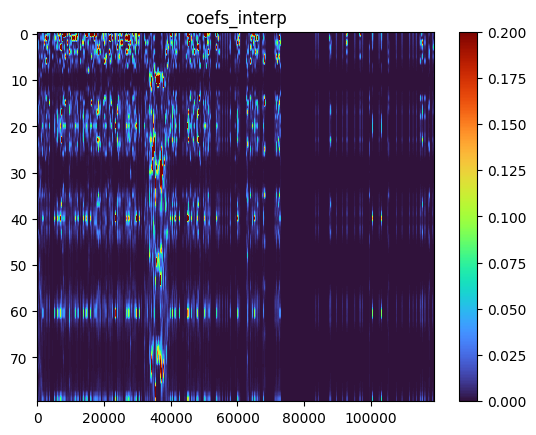

In [17]:
plt.imshow(np.abs(coefs_interp), aspect='auto', vmin=0, vmax=.2, cmap='turbo')
plt.colorbar()
plt.title('coefs_interp')
plt.show()


In [11]:
# Find segments of sufficient duration T
T